In [1]:
%autosave 300
%matplotlib inline
import matplotlib.pyplot as plt
from hidden import *  # Функции, реалзация которых не особо интересна в свете этой темы
from visual_utils import *

Autosaving every 300 seconds


In [2]:
source = [(4,0),(5,2),(3,3),(0,7),(-3,5),(-4,3),(-6,2),(-3,-1)]
source = list(map(lambda i: Vertex(i[0],i[1]), source))
D = build_dcel(source)

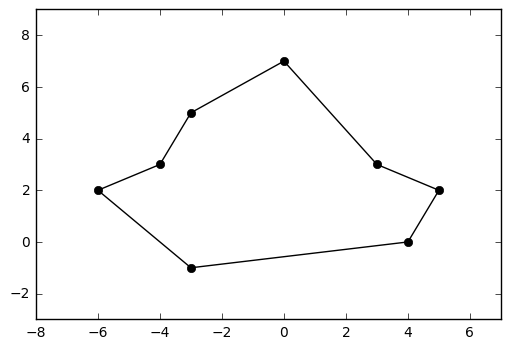

In [3]:
draw_points(source)

In [4]:
def different_chains(v1, v2):
    h1 = v1.hedgelist[1]
    h2 = v2.hedgelist[1]
    down1 = h1.origin < h1.twin.origin
    down2 = h2.origin < h2.twin.origin
    return down1 != down2

In [5]:
Q = list(sorted(source))
S = []  # Наш стек
D1 = [] # Добавленные диагонали
S.append(Q[0])
S.append(Q[1])

# Визуализация
c = 0 
folder = 'triang' 
os.makedirs(folder, exist_ok=True)
def dump(v):
    global c
    visual_dump_triang(v,D,D1,S,Q,os.path.join(folder,'{}.png'.format(c)))
    c += 1

for j in range(2, len(Q) - 1):
    dump(Q[j])
    if different_chains(Q[j],S[-1]):
        while len(S) > 0:
            if len(S) != 1:
                top = S.pop()
                D1.append(add_diagonal(Q[j].hedgelist[1],top.hedgelist[1]))
                dump(Q[j])
            else:
                S.pop()
        S.append(Q[j-1])
        S.append(Q[j])
        dump(Q[j])
    else:
        last = S.pop()
        while len(S) > 0 and turn(Q[j], last, S[-1]) > 0:
            last = S.pop()
            D1.append(add_diagonal(Q[j].hedgelist[1], last.hedgelist[1]))
            dump(Q[j])
        S.append(last)
        S.append(Q[j])
S.pop()
while len(S) > 0:
    if len(S) != 1:
        top = S.pop()
        D1.append(add_diagonal(Q[-1].hedgelist[1],top.hedgelist[1]))
        dump(Q[-1])
    else:
        S.pop()

dump(None)

In [6]:
from IPython.display import display

display(SlideShower(folder))